In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import scipy
import scipy.linalg as linalg
np.set_printoptions(precision=2,suppress=True)

# Minimizing the RSS
Assuming that we have now selected a function class, and that it can be modelled as a linear function $f(\vvec{x})=\bm\phi(\vvec(x))^\top\bm\beta$, we need to train the parameter vector $\bm\beta$ to fit the dataset. For that reason, we need to define an objective function that is small if the model $f(\vvec{x})$ is suitable. Since our goal is to approximate the target values, we can simly measure the distance of our prediction $f(\vvec{x})$ and the target value $y$.   
````{tikz}
%\pgfplotsset{
%	colormap={test}{[2pt]
%    	rgb=(0.8,0.2,0.4);
%       rgb=(0.8,0.2,0.4);
%    },
%}
\pgfplotsset{compat=newest}
\pgfmathsetseed{10} % set the random seed
\pgfplotstableset{ % Define the equations for x and y
    create on use/x/.style={create col/expr={42+2*\pgfplotstablerow}},
    create on use/y/.style={create col/expr={(0.6*\thisrow{x}+130)+8*rand}}
}
% create a new table with 30 rows and columns x and y:
\pgfplotstablenew[columns={x,y}]{30}\loadedtable

% Calculate the regression line
\pgfplotstablecreatecol[linear regression]{regression}{\loadedtable}

\pgfplotsset{
    colored residuals/.style 2 args={
        only marks,
        scatter,
        point meta=explicit,
        colormap={redblue}{color=(#1) color=(#2)},
        error bars/y dir=minus,
        error bars/y explicit,
        error bars/draw error bar/.code 2 args={
            \pgfkeys{/pgf/fpu=true}
            \pgfmathtruncatemacro\positiveresidual{\pgfplotspointmeta<0}
            \pgfkeys{/pgf/fpu=false}
            \ifnum\positiveresidual=0
                \draw [#2] ##1 -- ##2;
            \else
                \draw [#1] ##1 -- ##2;
            \fi
        },
        /pgfplots/table/.cd,
            meta expr=(\thisrow{y}-\thisrow{regression})/abs(\thisrow{y}-\thisrow{regression}),
            y error expr=\thisrow{y}-\thisrow{regression}
    },
    colored residuals/.default={magenta}{magenta}
}
\begin{tikzpicture}
\begin{axis}[
xlabel=$x$, % label x axis
ylabel=$y$, % label y axis
axis lines=left, %set the position of the axes
xmin=40, xmax=105, % set the min and max values of the x-axis
ymin=150, ymax=200, % set the min and max values of the y-axis
yticklabels={,,},xticklabels={,,}
]

\makeatletter
\addplot [colored residuals] table {\loadedtable};
\addplot [
    no markers,
    thick, blue
] table [y=regression] {\loadedtable} ;
\end{axis}
\end{tikzpicture}
````
The plot above shows a set of datapoints that are approximated by an affine model (blue). The distance to the target $y$, plotted on the vertical axis, is indicated by the red bars. The distance indicated by the red bars reflect the absolute values $\lvert y_i - f(\vvec{x}_i)\rvert$. However, the absolute value is not so easy to optimize, since it is non-differentiable at value zero. Instead, we can minimize the squared distances, which gives us a smooth objective function. 

The squared approximation error of a function $f$ to the target values $y$ can be compactly written as follows for a linear model $f(\vvec{x})=\bm\phi(\vvec(x))^\top\bm\beta$
\begin{align*}
    RSS(\bm{\beta}) &= \sum_{i=1}^n(y_i-f(D_{i\cdot}))^2\\
    &= \sum_{i=1}^n(y_i-\bm{\phi}(D_{i\cdot}^\top)^\top\bm{\beta})^2\\
    &= \sum_{i=1}^n(y_i-X_{i\cdot}\bm{\beta})^2\\
    &=\lVert \vvec{y}-X\bm{\beta}\rVert^2.
\end{align*}
The function $RSS(\bm{\beta})$ is called the **Residual Sum of Squares**. We have defined above the matrix $X$, that gathers the transformed feature vectors $\bm{\phi}(D_{i\cdot}^\top)^\top = X_{i\cdot}$ over its rows. 
The matrix $X$ is called the **design matrix**. Likewise, we can gather the target values in the vector $\vvec{y}$.
\begin{align*}
    X&= 
    \begin{pmatrix}
    -- & \bm{\phi}(D_{1\cdot}^\top)^\top &--\\
    &\vdots&\\
    --& \bm{\phi}(D_{n\cdot}^\top)^\top &--
    \end{pmatrix}
    \in\mathbb{R}^{n\times p},&
    \vvec{y}&=
    \begin{pmatrix}
    y_1\\ \vdots\\ y_n
    \end{pmatrix}
    \in\mathbb{R}^n
\end{align*}
We can now specify the linear regression task, using linear regression models and the squared Euclidean distance to measure the fit of the model.

`````{admonition} Task (Linear Regression with Basis Functions)
:class: tip
:name: regr_task
**Given** a dataset of $n$ observations
\begin{equation*}\mathcal{D}=\left\{(D_{i\cdot},y_i)\vert D_{i\cdot}\in\mathbb{R}^{1\times d}, y_i\in\mathbb{R}, 1\leq i \leq n\right\}\end{equation*}   
**Choose** a basis function $\bm\phi:\mathbb{R}^d\rightarrow \mathbb{R}^p$, and create the design matrix $X\in\mathbb{R}^{n\times p}$, where $X_{i\cdot}=\bm\phi(D_{i\cdot}^\top)^\top$     
**Find** the regression vector $\bm\beta$, solving the following objective
\begin{align*}
    \min_{\bm\beta} \ RSS(\bm\beta) = \lVert \vvec{y}-X\bm\beta\rVert^2 &\ 
    \text{s.t. } \bm\beta\in\mathbb{R}^p.
\end{align*}
**Return** the predictor function $f:\mathbb{R}^d\rightarrow\mathbb{R}$, $f(\vvec{x})=\bm\phi(\vvec{x})^\top\bm\beta$.  
`````

## Convexity of the RSS
The RSS is a convex optimization objective as it is a composition of an affine function and a convex function (the squared $L_2$-norm), which is again convex.
````{prf:theorem}
The function $RSS(\bm\beta)=\lVert \vvec{y}-X\bm{\beta}\rVert^2$ is convex.
````
````{prf:proof}
The squared $L_2$-norm $\lVert\cdot\rVert^2$ is a convex function. 

The composition of the affine function $g(\bm{\beta})=\vvec{y}-X\bm{\beta}$ with the convex function $\Vert\cdot\rVert^2$, given by the $RSS(\bm{\beta})=\lVert g(\bm{\beta})\rVert^2$ is then also convex.
````
As a corollary, the linear regression optimization objective
\begin{align*}
    \min_{\bm{\beta}}&\ RSS(\bm{\beta})& \text{s.t. }\bm{\beta}\in\mathbb{R}^p
\end{align*}
is convex, since the feasible set is the vector space of $\mathbb{R}^p$, which is convex.
So, we have an unconstrained convex optimization problem with a smooth objective function. That means that all stationary points must be minimizers. Let's try to find all stationary points.
## Minimizers of the RSS
We compute the stationary points by setting the gradient to zero. The gradient of the $RSS(\bm{\beta}) = \lVert \vvec{y}-X\bm{\beta}\rVert^2=f(\vvec{g}(\bm{\beta}))$ is computed by the chain rule, as discussed in {ref}`opt_exercises_gradients`. 
:::{math}
:label: eq:minimizers
\begin{align*}
\nabla_{\bm{\beta}} RSS(\bm{\beta})= -2X^\top(\vvec{y}-X\bm{\beta}) =0 
\quad \Leftrightarrow \quad
     X^\top X{\bm{\beta}} = X^\top \vvec{y}
\end{align*}
:::
According to FONC and convexity of the optimization objective, the global minimizers of the regression problem are given by the set of regression parameter vectors satisfying the equation above 
$$\{\bm{\beta}\in\mathbb{R}^p\mid X^\top X\bm{\beta} =X^\top\vvec{y} \}.$$

If the matrix $X^\top X$ is invertible, then there is only one minimizer. In this case we can solve the equation for $\bm{\beta}$ by multiplying with $(X^\top X)^{-1}$
$$\bm{\beta}= (X^\top X)^{-1}X^\top\vvec{y}.$$

However, there also might be _infinitely many_ global minimizers of $RSS(\bm{\beta})$. 

````{tikz}
\begin{tikzpicture}
\begin{axis}[
width=\textwidth,
xlabel=$x_1$, % label x axis
ylabel=$y$, % label y axis
axis lines=left, %set the position of the axes
xmin=0, xmax=7, % set the min and max values of the x-axis
domain=0:6,
ymax=12, % set the min and max values of the y-axis
legend pos=outer north east]
\addplot [only marks, black, mark = *] 
coordinates {
(5,2)
(3,5)
(1,3)
};
\addplot+[magenta,thick,smooth, mark=none]
{x^3-(5/8+9)*x^2+(7/2+23)*x+1/8-15};
\addplot+[blue,thick,smooth, mark=none]
{x^3/2-(5/8+9/2)*x^2+(7/2+23/2)*x+1/8-15/2};
\addplot+[green,thick,smooth, mark=none]
{x^3/4-(5/8+9/4)*x^2+(7/2+23/4)*x+1/8-15/4};
\end{axis}
\end{tikzpicture}
````

In [2]:
# calculations invisible
D = np.array([5,3,1])
y = np.array([2,5,3])
def ϕ(x):
    return np.row_stack((np.ones(x.shape[0]),x, x**2, x**3))
X=ϕ(D).T
print(X.T@X,X.T@y)
A = X.T@X
b = X.T@y
A1=np.vstack((A[0,:]/3,A[1,:]-A[0,:]*3, A[2,:] - A[0,:]/3*35, A[3,:] - A[0,:]/3*153))
b1=np.vstack((b[0]/3,b[1]-b[0]*3, b[2] - b[0]/3*35, b[3] - b[0]/3*153))
A1,b1
A2=np.vstack((A1[0,:],A1[1,:]/8, A1[2,:] - A1[1,:]/8*48, A1[3,:] - A1[1,:]/8*248))
b2 = np.vstack((b1[0],b1[1]/8, b1[2] - b1[1]/8*48, b1[3] - b1[1]/8*248))
A2,b2
A3=np.vstack((A2[0,:],A2[1,:], A2[2,:]/A2[2,2], A2[3,:] - A2[2,:]/A2[2,2]*96))
b3=np.vstack((b2[0],b2[1], b2[2]/A2[2,2], b2[3] - b2[2]/A2[2,2]*96))
A3,b3

[[    3.     9.    35.   153.]
 [    9.    35.   153.   707.]
 [   35.   153.   707.  3369.]
 [  153.   707.  3369. 16355.]] [ 10.  28.  98. 388.]


(array([[ 1.  ,  3.  , 11.67, 51.  ],
        [ 0.  ,  1.  ,  6.  , 31.  ],
        [ 0.  ,  0.  ,  1.  ,  9.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ]]),
 array([[ 3.33],
        [-0.25],
        [-0.62],
        [-0.  ]]))

## Getting all Regression Solvers
If the matrix $X^\top X$ is not invertible, then we have infinitely many regression solvers. This is particularly the case when $p>n$.

````{prf:example} Regression with $p>n$
:label: example_reg_p_larger_n
We consider a toy regression task, where the data is given by following three data points (observations) of one feature.

    D = np.array([5,3,1])
    y = np.array([2,5,3])
    pandas.DataFrame({"F1":D,"y":y})

That is, our given data looks as follows:
 
 $x$ | $y$ 
----------------|----------------
5 | 2 
3 | 5 
1 | 3 

We fit a polynomial of degree $k=3$. For polynomial regression functions $f:\mathbb{R}\rightarrow\mathbb{R}$ we have
$$f(x) = \beta_0 +\beta_1 x+ \beta_2x^2 + \beta_3x^3 = \phi(x)^\top\bm\beta,$$
where 
$$\bm\phi(x)^\top=\begin{pmatrix}1& x& x^2& x^3\end{pmatrix}.$$
The design matrix gathers the transposed feature vectors of the data matrix:
$$X = \begin{pmatrix} \phi^\top(5)\\ \phi^\top(3)\\ \phi^\top(1)\end{pmatrix} = \begin{pmatrix} 1 & 5 & 25 & 125\\ 1 & 3 & 9 & 27\\ 1 & 1 & 1 & 1\end{pmatrix}$$
We have $n=3$ observations of $p=4$ features in the design matrix, and hence, $p>n$.

We have to solve the system of equations given by $X^\top X \bm\beta = X^\top \vvec{y}$:
\begin{align*}
\begin{pmatrix}
3 &     9 &    35 &   153\\
9 &    35 &   153 &   707\\
35&   153 &   707 &  3369\\
153&  707 &  3369 & 16355
\end{pmatrix} \bm\beta = 
\begin{pmatrix}
10\\  28\\  98\\ 388
\end{pmatrix}
\end{align*}
We can solve this system of equations by hand. There are multiple ways to do this. One is to transform the equations above into an upper triangle form. We detail the steps to do this in {ref}`reg_exercises`. As a solution set of regression solvers in dependence of $\beta_3$, we get 
$$\left\{\beta = \begin{pmatrix}\frac{1}{8}-15\beta_3\\3.5 +23\beta_3\\-\frac{5}{8} -9\beta_3\\\beta_3 \end{pmatrix} \mid \beta_3\in\mathbb{R} \right\}.$$
```{tikz}
\begin{tikzpicture}
\begin{axis}[
width=.8\textwidth,
xlabel=$x_1$, % label x axis
ylabel=$y$, % label y axis
axis lines=left, %set the position of the axes
xmin=0, xmax=7, % set the min and max values of the x-axis
domain=0:6,
ymax=12, % set the min and max values of the y-axis
legend pos=outer north east]
\addplot+[only marks, black, mark = *] 
coordinates {
(5,2)
(3,5)
(1,3)
};
\addlegendentry{Data Points}
\addplot+[magenta,thick,smooth, mark=none]
{x^3-(5/8+9)*x^2+(7/2+23)*x+1/8-15};
\addlegendentry{$\beta_3=1$}
\addplot+[blue,thick,smooth, mark=none]
{x^3/2-(5/8+9/2)*x^2+(7/2+23/2)*x+1/8-15/2};
\addlegendentry{$\beta_3=0.5$}
\addplot+[green,thick,smooth, mark=none]
{x^3/4-(5/8+9/4)*x^2+(7/2+23/4)*x+1/8-15/4};
\addlegendentry{$\beta_3=0.25$}
\end{axis}
\end{tikzpicture}
```
````
In the example above, we could compute the set of regression vectors by hand, but how can we compute the set of regression vectors when the dataset bigger? How can we numerically compute the set of all regression vectors?

In this case ($p>n$), the matrix $X^\top X$ is not invertible. When you try to compute the inverse of $X^\top X$ by hand, then you will get a contradiction. If we compute the inverse numerically with `np.linalg.inv(X.T@X)`, then you will see that the computed "inverse" has extremely large values (in the scope of $10^13$ to $10^14$). This corresponds to the fact that we are trying to divide by zero (in a matrix way). Generally, you can assume that such extreme values (either being very close to zero like `1e-16` or very big like `1e16`) indicates values that are actually equal to infinity or equal to zero.

Anyways, we can easily check how good the computed inverse is, by multiplying the "inverse" with the matrix itself. The multiplication of the computed inverse and the matrix itself should return an approximate identity matrix. However, if we check `np.linalg.inv(X.T@X)@(X.T@X)`, then we see that this matrix is nowhere near the identity matrix.

In turn, what mostly works is to use a numerical solver for the system of linear equations which returns the global minimizers $\beta$ of the regression objective
$$\{\beta\in\mathbb{R}^p\mid X^\top X\beta = X^\top y\}.$$

With `β = linalg.solve(X.T@X,X.T@y)` yields a solution for $\beta$, but returns a warning that the result might not be accurate. We observe that this result is accurate and by checking if $X^\top X\beta = X^\top y$. You can do this  by inspecting `X.T@X@β, X.T@y`, which indeed returns the same vector.  

### Characterizing the Set of Regression Solvers with SVD
We derive now a general solution for the (set of) regression solvers.
to do so, we have a look into the SVD of $X$, that gives us more insight into the regression equation when $X^\top X$ is not invertible. You might remember from the linear algebra recap, that the invertibility of a matrix is determined by the singular values of the matrix: if all the singular values are larger than zero, then the matrix is invertible, otherwise not. The singular values of $X^\top X$ are determined by the singular values of $X=U\Sigma V^\top$, since we have
\begin{align*}
    X^\top X = V\Sigma^\top \underbrace{U^\top U}_{=I} \Sigma V^\top = V\Sigma^\top \Sigma V^\top.
\end{align*}

 The singular value decomposition is uniquely defined and the decomposition $V\Sigma^\top \Sigma V^\top$ satisfies the requirements for the singular value decomposition of $X^\top X$. Hence, the singular values of $X^\top X$ are given by the diagonal elements of the matrix $\Sigma^\top \Sigma$. Let $r$ be the rank of the matrix $X$, that is the number of nonzero singular values. If $n<p$, then we know that $r\leq n$. That is, the matrix $\Sigma$ looks like
\begin{align}
\Sigma= 
\left(
\begin{array}{c:r}
\begin{matrix}
\sigma_1 & \ldots & 0  \\
\vdots  & \ddots  & \vdots \\
0 & \ldots   & \sigma_r \\
& \vvec{0} &
\end{matrix} & \vvec{0}
\end{array}
\right) 
= \left(
\begin{array}{c:r}
\begin{matrix}\Sigma_r\\\vvec{0}\end{matrix} & \vvec{0} \\ 
\end{array}
\right).
\label{eq:STS}
\end{align}

Given the singular value decomposition of $X$, we can try to solve Eq. {eq}`eq:minimizers` for $\bm\beta$:
\begin{align}
   X^\top X\bm{\beta} &= X^\top \vvec{y} \quad 
   \Leftrightarrow \quad V\Sigma^\top\Sigma V^\top \bm{\beta}= V\Sigma^\top U^\top\vvec{y}
   \quad 
   \Leftrightarrow \quad \Sigma^\top\Sigma V^\top \bm{\beta}= \Sigma^\top U^\top\vvec{y}, \label{eq:beta1}
\end{align}
where the last equality follows from multiplying with $V^\top$ from the left.

````{prf:observation} Characterization of Regression solvers by SVD
The global minimizers $\bm{\beta}$ to the {ref}`Linear Regression<regr_task>` task with design matrix $X$, having the SVD $X=U\Sigma V^\top$, are given by
$$\{\bm{\beta}\in\mathbb{R}^p\mid \Sigma^\top\Sigma V^\top \bm{\beta}= \Sigma^\top U^\top\vvec{y} \}.$$
````
$\Sigma^\top\Sigma\in\mathbb{R}^{p\times p}$ is a diagonal matrix, where not all elements on the diagonal are nonzero if $n<p$. Hence, it does **not** have an inverse if $n<p$. This becomes maye a bit more clear when we look at the following observation

(obs:sigma_r)=
````{prf:observation} Singular value matrix of rank $r$
Let $X\in\mathbb{R}^{n\times p}$ be a matrix with rank $r$, meaning that $X$ has only $r$ nonzero singular values. Let $X=U\Sigma V^\top$ be the SVD of $X$, then the matrix $\Sigma$ looks as follows:
\begin{align*}
\Sigma= 
\left(
\begin{array}{c:r}
\begin{matrix}
\sigma_1 & \ldots & 0  \\
\vdots  & \ddots  & \vdots \\
0 & \ldots   & \sigma_r \\
& \vvec{0} &
\end{matrix} & \vvec{0}
\end{array}
\right) 
= \left(
\begin{array}{c:r}
\begin{matrix}\Sigma_r\\\vvec{0}\end{matrix} & \vvec{0} \\ 
\end{array}
\right).
\end{align*}
The matrices $\vvec{0}$ indicate here constant zero matrices whose dimensionalities are inferred from context. The constant zero matrix below $\Sigma_r$ has a dimensionality of $n-r\times r$ and the constant zero matrix on the right has a dimensionality of $n\times p-r$. Correspondingly, if $n=r$, then the lower zero matrix doesn't exist and if $r=p$, then the zero matrix on the right doesn't exist. 
````
The notation of Observation {ref}`obs:sigma_r` helps us now to derive the set of all regression solvers.

````{prf:theorem} Set of all regression solvers
Let $X=U\Sigma V^\top\in\mathbb{R}^{n\times p}$ be the SVD of the design matrix of the {ref}`Linear Regression<regr_task>` task. If only $r<p$ singular values of $X$ are nonzero ($X$ has a rank of $r$), then the set of global minimizers $\bm{\beta}$ is given by
$$\left\{\bm{\beta}= V\begin{pmatrix}\Sigma_r^{-1} U_r^\top\vvec{y}\\z\end{pmatrix}\mid z\in\mathbb{R}^{p-r} \right\}.$$
$\Sigma_r$ denotes here the matrix containing only the first $r$ rows and columns of the singular values matrix $\Sigma$ and $U_r$ denotes the matrix containing the first $r$ left singular vectors (the first $r$ columns of $U$).
````
````{toggle}
```{prf:proof}
We start at the characterization of regression solvers by SVD (Observation):
\begin{align}
\Sigma^\top\Sigma V^\top\bm\beta &= \Sigma^\top U_r^\top y\\
\Leftrightarrow
\left(\begin{array}{cc}
\begin{matrix}
\Sigma_r&\vvec{0}\end{matrix} \\\hdashline \vvec{0} 
\end{array}\right)
\left(
\begin{array}{c:r}
\begin{matrix}\Sigma_r\\\vvec{0}\end{matrix} & \vvec{0} \\ 
\end{array}
\right)
V^\top \bm\beta &=  \left(\begin{array}{cc}
\begin{matrix}
\Sigma_r&\vvec{0}\end{matrix} \\\hdashline \vvec{0} 
\end{array}\right) U_r^\top y
\end{align}
We see here that only the first $r$ equations are relevant, the remaining equations $0=0$ are evidently true. We further shorten the notation by setting $\hat{\bm\beta}=V^\top\bm\beta$. We have then
\begin{align}
\Sigma_r\begin{pmatrix} \Sigma_r & \vvec{0}\end{pmatrix}\hat{\bm\beta} &= \Sigma_r U_r^\top y\\ 
\Leftrightarrow
\begin{pmatrix} \Sigma_r & \vvec{0}\end{pmatrix}\hat{\bm\beta} &= U_r^\top y\\ 
\Leftrightarrow
\begin{pmatrix} I_r & \vvec{0}\end{pmatrix}\hat{\bm\beta} &= \Sigma_r^{-1} U_r^\top y\\
\Leftrightarrow
\hat{\bm\beta}_{0:r} &= \Sigma_r^{-1} U_r^\top y
\end{align}
We see that only the first $r$ coordinates of $\hat{\bm\beta}$ are determined by the given equation. What we have in the rest of the coordinates is free to choose and the equation will still hold. We model the coordinates that are free to choose with the vector $z$. Then we have

\begin{align}
\hat{\bm\beta} &= \begin{pmatrix}\Sigma_r^{-1} U_r^\top y\\z \end{pmatrix}\\
\Leftrightarrow V^\top\bm\beta &= \begin{pmatrix}\Sigma_r^{-1} U_r^\top y\\z \end{pmatrix}\\
\Leftrightarrow \bm\beta &= V\begin{pmatrix}\Sigma_r^{-1} U_r^\top y\\z \end{pmatrix}
\end{align}

```
````

## Example Determination of Regression Solvers by SVD
We consider again the data from {prf:ref}`example_reg_p_larger_n`. Yet, instead of computing the solution by hand, we implement now a general scheme to obtain the set of regression vectors. First, we compute the SVD of the design matrix $X$

In [3]:
D = np.array([5,3,1])
y = np.array([2,5,3])
def ϕ(x):
    return np.row_stack((np.ones(x.shape[0]),x, x**2, x**3))
X=ϕ(D).T
U,σs,Vt = linalg.svd(X, full_matrices=True)
V=Vt.T

When we look at the singular values, then we have $r=3<4=p$.

In [4]:
σs

array([130.7 ,   4.2 ,   0.84])

Correspondingly, the matrix $\Sigma^\top$ has a row of zeros at the bottom.

In [5]:
Σ = np.column_stack((np.diag(σs),np.zeros(3)))
Σ.T

array([[130.7 ,   0.  ,   0.  ],
       [  0.  ,   4.2 ,   0.  ],
       [  0.  ,   0.  ,   0.84],
       [  0.  ,   0.  ,   0.  ]])

Correspondingly, we see in the set of equations given by $\Sigma^\top \Sigma V^\top \beta = \Sigma^\top U \vvec{y}$ that the last equation is always true ($0=0$).

In [6]:
print(Σ.T@Σ@V.T,"β=",Σ.T@U@y)

[[  157.18   724.22  3445.93 16714.05]
 [   -4.36    -8.61   -14.36     3.38]
 [    0.58     0.25    -0.32     0.05]
 [    0.       0.       0.       0.  ]] β= [415.45 -21.56   1.04   0.  ]


\begin{align*}
\begin{pmatrix}
 157.18 &   724.22 &  3445.93 & 16714.05\\
 -4.36  &  -8.61  & -14.36   &  3.38\\
 0.58   & 0.25   & -0.32    & 0.05\\
 0      & 0      & 0        & 0
\end{pmatrix}
\beta &= 
\begin{pmatrix}
415.45 \\ -21.56 \\ 1.04 \\   0
\end{pmatrix}
\end{align*}

We have an underdetermined system. There are only 3 equations to determine 4 parameters of $\beta$. If you are going to solve this system by hand, then you will see that one parameter is always left over (it can't be determined by the given equations). Setting this parameter to any number yields then one of the infinite solutions to the regression problem. For example, we can set $\beta_3=2$.  

We can now calculate a $\beta$ in the set of global minimizers. If ```random=True``` then a random matrix replaces the zero rows in the pseudo inverse of $\Sigma^\top\Sigma$.

In [7]:
def get_beta(U,Σ,V,random =True):
    Σ_pseudoinv = Σ.copy()
    Σ_pseudoinv[Σ>0] = 1/Σ[Σ>0]
    w = Σ_pseudoinv.T@U.T@y
    if random:
        p=V.shape[1]
        r=(Σ>0).sum() # the number of nonzero singular values
        w[r:p]=np.random.rand(p-r)*50
    return V@w

Plot it! The function resulting from setting ```random=False``` is the one in blue.

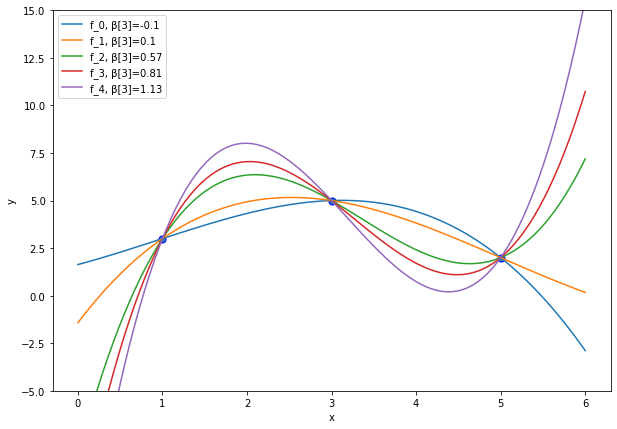

In [8]:
plt.figure(figsize=(10, 7))
x = np.linspace(0, 6, 100)
β = get_beta(U,Σ,V,random = False)
f_x = ϕ(x).T@β
plt.plot(x, f_x, label="f_0"+", β[3]="+str(np.round(β[3],2)))
for i in range(1,5):
    β = get_beta(U,Σ,V)
    f_x = ϕ(x).T@β
    plt.plot(x, f_x, label="f_"+str(i)+", β[3]="+str(np.round(β[3],2)))
plt.scatter(D, y, edgecolor='b', s=50)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim((-5, 15))
plt.legend(loc="best")
plt.show()